# Data Classification from Image Features

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [14]:
X = pd.read_csv("X_train.csv").drop('id', axis=1).to_numpy()
y = pd.read_csv("y_train.csv").drop('id', axis=1).to_numpy()
X_end_test = pd.read_csv("X_test.csv").drop('id', axis=1)
print(X, '\n', y)

[[-1.09914374e+00  9.18165326e-01 -1.22739446e+00 ...  3.49724579e+00
  -1.27542198e+00  2.44070840e+00]
 [ 3.66476595e-01  9.33802187e-01  6.12344030e-02 ... -1.50495410e-01
   1.56421304e-01  7.14251935e-01]
 [-4.25878823e-01 -8.02152276e-01  2.71817100e-03 ...  7.66521692e-01
   3.39105397e-01 -4.63639050e-02]
 ...
 [-3.06731430e-02  3.21549177e-01 -9.26858783e-01 ...  1.96702921e+00
  -6.18075728e-01  1.75024950e+00]
 [ 3.56795380e-02  1.48401722e-01  8.57769012e-01 ...  2.94511139e-01
  -3.28029156e-01 -1.13899067e-01]
 [-2.34110653e-01 -4.33427542e-01 -6.85740930e-02 ...  8.93944383e-01
  -1.82160199e-01  4.60182697e-01]] 
 [[1]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


## Pre-processing of the Data

### Assert if Data is Invalid

In [5]:
assert np.all(np.isfinite(X)) and np.all(np.isfinite(y))

### Normalization

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)

### Looking for Non-Informative Features
TODO: Think about _n\_components_ and _percentile_ parameters values.

408 Features Removed


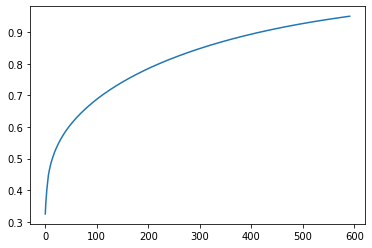

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X_norm)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print("%d Features Removed" % (X.shape[1] - X_pca.shape[1]))

In [5]:
from sklearn.feature_selection import \
mutual_info_classif, SelectPercentile
X_mutual_info = SelectPercentile(mutual_info_classif, percentile=50) \
                    .fit_transform(X_pca, y.ravel())
print("%d Features Removed" % (X_pca.shape[1] - X_mutual_info.shape[1]),
     "\nThere are %d features left" % X_mutual_info.shape[1])

296 Features Removed 
There are 296 features left


## Dealing with Class Imbalance
_Note: This actually depends on the classification procedure; with 'One vs. All' there will be always a class 
imbalance._ 

TODO: Think about the best numbers for oversampling and maybe use bias

In [18]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print("Original dataset shape %s:" % Counter(y.ravel()))
X_oversampled, y_oversampled = SMOTE(sampling_strategy={
                                          0: 3600,
                                          1: 3600,
                                          2: 3600}).\
                            fit_sample(X_mutual_info, y.ravel())
print("Oversampled dataset shape %s:" % Counter(y_oversampled))

Original dataset shape Counter({1: 3600, 0: 600, 2: 600}):
Oversampled dataset shape Counter({1: 3600, 0: 3600, 2: 3600}):


## Fiddling Around with Some Classification Algorithms

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
                X_oversampled, y_oversampled, test_size=0.33)
print("Training dataset shape %s:" % Counter(y_train.ravel()))
classifiers = {
    'Random Forests': RandomForestClassifier(max_depth=5,
                                              n_estimators=10,
                                              max_features=1),
    'NN': MLPClassifier(hidden_layer_sizes=(33, 33, 33),
                         alpha=1, max_iter=1000)
}
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    print("Score of %s is %0.4f" % (name,
          balanced_accuracy_score(y_true=y_test, y_pred=prediction, adjusted=True)))

NameError: name 'X_oversampled' is not defined


## Creating a Pipeline and Cross Validation Procedure for the Actual Learning
Some remarks:
1. _best\_classifier.fit(...)_ function is time consuming (!), use with caution.

In [43]:
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif, SelectPercentile
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import (GridSearchCV,
    cross_val_score, StratifiedKFold)
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

pipeline = make_pipeline(StandardScaler(),
                         PCA(),
                         SelectPercentile(f_classif),
                         SVC(decision_function_shape='ovr', class_weight='balanced',
                            gamma='scale',
                            kernel='rbf'))
parameter_space = {
    'svc__C': [10, 1, 0.1],
    'svc__degree': [3],
    'selectpercentile__percentile':[20, 50],
    'pca__n_components':[0.80]
}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
best_classifier = GridSearchCV(pipeline, parameter_space,
                               n_jobs=1, scoring='balanced_accuracy',
                               verbose=True, iid=False,
                               cv=inner_cv)
scores = cross_val_score(best_classifier, X, y.ravel(),
                            cv=outer_cv,
                            scoring='balanced_accuracy',
                            n_jobs=-1,
                            verbose=True)

print("Cross-validation score is %0.4f" % scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross-validation score is 0.6948


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


## Save the Results

In [44]:
best_classifier.fit(X, y.ravel())
print("Best estimators parameters:\n",
      pd.DataFrame(best_classifier.cv_results_))
y_pred = best_classifier.predict(X_end_test)
id = [float(i) for i in range(0, len(y_pred))]
df = pd.DataFrame({'id': id, 'y': y_pred})
df.to_csv('solution.csv', index=False)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.5min finished


Best estimators parameters:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.045359      0.036146         0.181424        0.002267   
1       2.105671      0.006495         0.197390        0.001502   
2       2.258622      0.026824         0.216364        0.001850   
3       2.890190      0.018662         0.362867        0.002799   
4       3.200663      0.008333         0.399780        0.003180   
5       3.538492      0.014324         0.437000        0.001854   

  param_pca__n_components param_selectpercentile__percentile param_svc__C  \
0                     0.8                                 20           10   
1                     0.8                                 20            1   
2                     0.8                                 20          0.1   
3                     0.8                                 50           10   
4                     0.8                                 50            1   
5                     0.8              